In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import numpy as np

import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import matplotlib.cm as cm

Notes

1. Rather than modeling rotation on wind, consider it as a negative displacement (i.e., if the wind is +x m/s @ +y°, just use displacement)

In [ ]:
### function to plot trajectory ###

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]

def plot_trajectory(states, angle=0, runway_length=(-1000, 1000), runway_boundaries=(-10, 10), verbose=False):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    for i, state in enumerate(states):
        x, y, vx, vy = state
        x, y = rotate(x, y, angle)
        heading = np.rad2deg(np.arctan2(vy, vx)) % 360
        if verbose:
            print(x, y, heading)
        plt.plot(x, y, marker=(3, 0, heading - runway_heading + zero_heading + 90), markersize=5, color=colors[i])   

In [ ]:
from torch.utils.data import Dataset

def buildDataset(n, seq_len):
    dataset, initialStates = [], []

    for _ in range(n):
        x = np.random.normal(0, 10)
        y = np.random.normal(0, 10)
        vx = np.random.normal(0, 35)
        vy = np.random.normal(0, 35)
        # x, y = 7.1272, 21.8248
        # vx, vy = -1.8361, 0
        # x, y = 1.4933, 3.9145
        # vx, vy = -10.1508, 1.6241

        # x, y = 11.8078, -19.1247
        # vx, vy = 23.8204, 15.7388

        dataset.append([[x, y, vx, vy]] * seq_len)
        initialStates.append([[x], [y], [vx], [vy]])
    
    dataset = np.array(dataset)
    initialStates = np.array(initialStates)
    return dataset, initialStates


class ControlsDataset(Dataset):
    def __init__(self, data):
        self.data = data


    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return self.data[0][idx], self.data[1][idx]

# a, b = buildDataset(2, 5)

In [ ]:
# MODEL

# class SamplingNetwork(nn.Module):
#     def __init__(self, states, samples):
#         super(SamplingNetwork, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(states),
#             nn.BatchNorm1d(),
#             nn.ReLU(),
#             nn.Linear(states * 2),
#             nn.BatchNorm1d(),
#             nn.ReLU(),
#             nn.Linear(states * samples),
#             nn.BatchNorm1d(),
#             nn.ReLU(),
#             # ADD CONV1D FOR TEMPORAL???
#         )

#     def forward(self, x):
#         # batch, parameters, value
#         y = self.network(x)
#         # batch, samples, parameters, value
#         return y


# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, gpu=0):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.gpu = gpu
    
    def forward(self, x):
        batch_size = x.size(0)

        # Set initial hidden and cell states 
        if self.gpu:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double).cuda()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double).cuda()
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double)
            
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc1(out)
        out = nn.Tanh()(out)

        out = torch.unsqueeze(out, axis=-1)

        return out


# class ControllerNetwork(nn.Module):
#     def __init__(self, samples,  states, controls):
#         super(QTableOptimizer, self).__init__()
#         self.controller = nn.Sequential(
#             nn.Linear(),
#             nn.BatchNorm1d(),
#         )
#         self.sampler = SamplingNetwork(states, samples)
        
    
#     def forward(self, x):
#         z = self.sampler(x)
#         y = self.controller(z)
#         return y

In [ ]:
# Test the model that was trained

# batch_size = 10
# n_workers = 1

# n_steps = 8

# n_features = 4
# n_layers = 7

# hidden_dim = n_features
# output_size = n_features

# zero_heading = 270 # degrees(°)
# runway_heading = 54.331

# runway_rotation = -(runway_heading + zero_heading - 360)

# best_path = '/content/drive/My Drive/Research/cc_best.pth'

# model = RNN(n_features, hidden_dim, output_size, n_layers)
# model = model.double()
# model.load_state_dict(torch.load(best_path))

# x, initial_states = buildDataset(1, n_steps)
# x = torch.tensor(x, dtype=torch.double)

# controls_output = model(x)
# print_states = getUpdatedStates(initial_states, controls_output.detach().numpy())
# plot_trajectory(print_states, runway_rotation, verbose=0)

In [ ]:
update_matrix = lambda t: torch.tensor(np.array([[1, 0, t, 0],
                                                 [0, 1, 0, t],
                                                 [0, 0, 1, 0],
                                                 [0, 0, 0, 1]]),
                                       dtype=torch.double)


# state: [[x1, y1, vx1, vy1], [x2, y2, vx2, vy2], ...]
# controls: [noise_x, noise_y, ax, ay]
def stateUpdateEqn(state, controls, stateTransition, timeStep):
    return torch.matmul(stateTransition, state) + timeStep * controls


def rejectionDist(x, y, centerLine, gpu):
    # see here: http://www.math.lsa.umich.edu/~glarose/classes/calcIII/web/13_5/
    projection = (centerLine[0] * x + centerLine[1] * y) / torch.square(torch.norm(centerLine, p=2)) * centerLine
    # projection = torch.matmul(centerLine, position) / torch.norm(centerLine, p=2) ** 2 * centerLine
    # sign of x-value, # [0] is projection on x [1] is projection on y
    # sign = math.copysign(1, x - projection[0]) 
    return torch.sqrt(torch.square(x - projection[0]) + torch.square(y - projection[1])) # * sign


constraints = np.array([[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 7, 0],
                        [0, 0, 0, 7]])


class LossFn(nn.Module):

    constraints = torch.tensor(constraints, dtype=torch.double)
    
    def __init__(self, 
                 desiredStates, 
                 centerLine, 
                 costWeights,
                 timeStep=1,
                 gpu=False):
        super(LossFn, self).__init__()
        self.centerLineWeight, self.velocityWeight, self.headingWeight = costWeights
        self.desiredVelocity, self.desiredHeading = desiredStates
        self.centerLine = centerLine
        self.timeStep = timeStep
        self.stateTransition = update_matrix(timeStep)
        self.gpu = gpu
        if gpu:
            self.constraints = self.constraints.cuda()
            self.stateTransition = self.stateTransition.cuda()
        

    def forward(self, initialState, controls, verbose=1):
        totalBatchCost = 0
        batchDim = initialState.size(0)
        
        for i in range(batchDim):
            cost = 0
            state = initialState[i,...]
            for j in range(controls.size(1)):
                state = stateUpdateEqn(state, torch.matmul(self.constraints, controls[i,j,...]), self.stateTransition, self.timeStep)

                x, y, vx, vy = torch.squeeze(state)
                velocity = torch.sqrt(torch.square(vx) + torch.square(vy))
                heading = torch.remainder(torch.rad2deg(torch.atan2(vy, vx)), 360)
                
                if verbose:
                    print(f"state {j+1}:")
                    print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
                    print("distance error:", rejectionDist(x, y, self.centerLine, self.gpu))
                    print("heading error:", torch.abs(heading - self.desiredHeading))
                    print("velocity error:", torch.abs(velocity - self.desiredVelocity))

                centerLineWeight = self.centerLineWeight * (j + 1)
                velocityWeight = self.velocityWeight * (j + 1)
                headingWeight = self.headingWeight * (j + 1)

                cost += centerLineWeight * rejectionDist(x, y, self.centerLine, self.gpu)
                cost += velocityWeight * torch.abs(velocity - self.desiredVelocity)
                cost += headingWeight * torch.abs(heading - self.desiredHeading)

            totalBatchCost += cost / controls.size(1)

        return totalBatchCost / batchDim


# state: [[x1, y1, vx1, vy1], [x2, y2, vx2, vy2], ...]
# controls: [noise_x, noise_y, ax, ay]
def stateUpdateEqnNumpy(state, controls, timeStep):
    update_matrix = lambda t: np.array([[1, 0, t, 0],
                                        [0, 1, 0, t],
                                        [0, 0, 1, 0],
                                        [0, 0, 0, 1]])
    stateTransition = update_matrix(timeStep)
    return stateTransition@state + timeStep * controls

def getHeading(control):
    _, _, ax, ay = control
    return math.degrees(np.arctan(ay / ax)) % 360

def getUpdatedStates(initialState, controls, timeStep=1):
    state = initialState[0]
    states = [state]
    for control in controls[0]:
        state = stateUpdateEqnNumpy(state, constraints @ control, timeStep)
        states.append(state)
    return states

# for testing purposes only
def generateRandomControls(n):
    controls = []
    batch_control = []
    for _ in range(n):
        ax = 1 / 10
        ay = -.715930 / 10
        batch_control.append([[0], [0], [ax], [ay]])
    controls.append(batch_control)
    return np.array(controls)

Number of trainable params in model: 500
inital heading 329.22354728320136
loss = 9416.136855430042



loss = 3377.2509344567175



loss = 3337.88757049298



loss = 3325.9788774979124



loss = 3321.843209384181



loss = 3316.754587749076





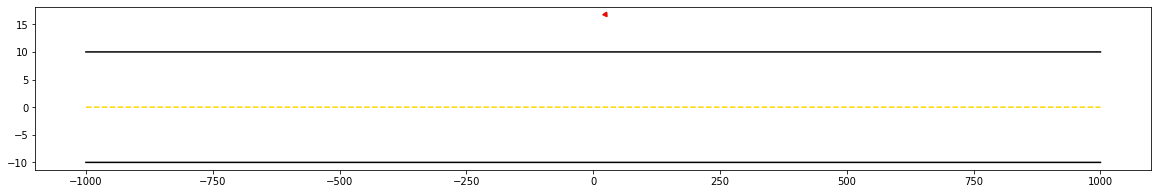

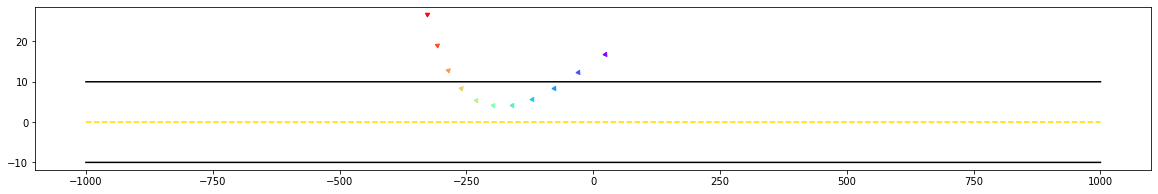

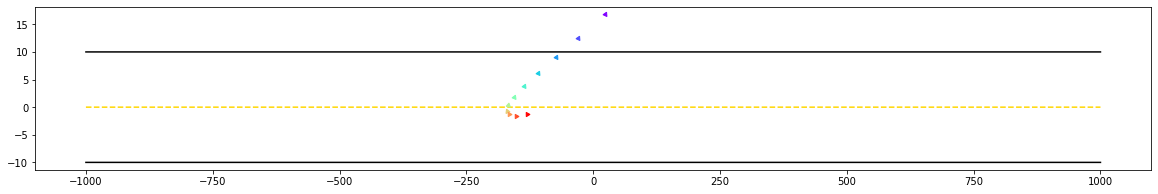

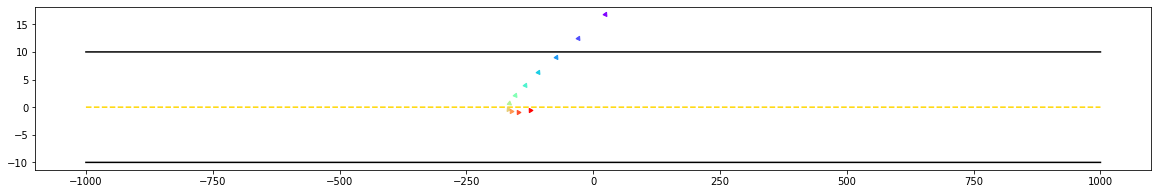

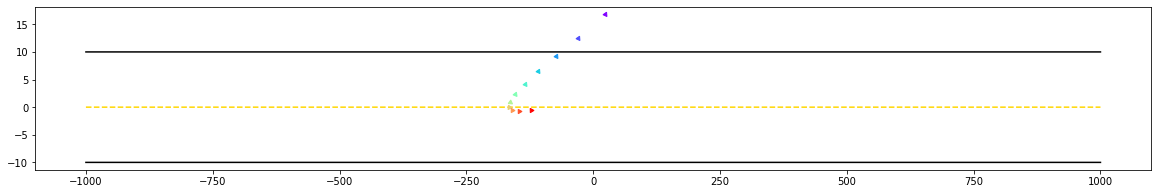

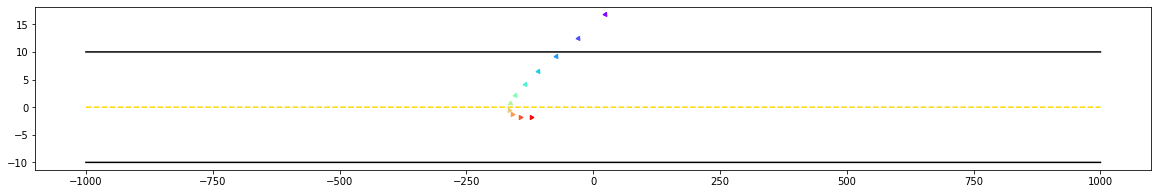

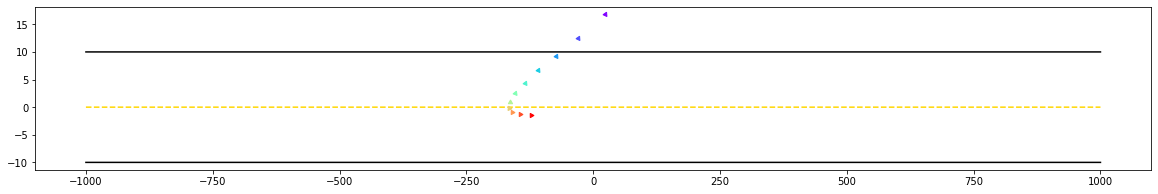

In [ ]:
from torch.utils.data import DataLoader

n_steps = 10

n_features = 4
n_layers = 3

hidden_dim = n_features
output_size = n_features

zero_heading = 270 # degrees(°)
runway_heading = 54.331
desired_states = (50, runway_heading + zero_heading) # m/s, degrees(°)
center_line = torch.tensor([2421, -1737], dtype=torch.double)
cost_fn_weights = [9, 2, 8] # centerLineWeight, velocityWeight, headingWeight


runway_rotation = -(runway_heading + zero_heading - 360)
# runway_rotation = -np.degrees(np.arctan(-1737 / 2421))

model = RNN(n_features, hidden_dim, output_size, n_layers)
model = model.double()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable params in model: {pytorch_total_params}')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = LossFn(desired_states, center_line, cost_fn_weights)

x, initial_states = buildDataset(1, n_steps)
x = torch.tensor(x, dtype=torch.double)
initial_states = torch.tensor(initial_states, dtype=torch.double)

print("inital heading", getHeading(np.squeeze(initial_states)))

# # for testing only
# test_trajectory = getUpdatedStates(initial_states.detach().numpy(), generateRandomControls(6))

plot_trajectory(x.detach().numpy()[0], runway_rotation)

epochs = 1001
display = 200

for epoch in range(epochs + 1):
    model.train()

    controls_output = model(x)
    loss = loss_fn(initial_states, controls_output, verbose=0) # epoch % display == 0)

    if epoch % display == 0:
        print_states = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy())
        plot_trajectory(print_states, runway_rotation, verbose=0)
        print(f'loss = {loss}')
        print('\n')

    model.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# from torch.utils.data import DataLoader

# batch_size = 10
# n_workers = 1

# n_steps = 8

# train_dataset = ControlsDataset(buildDataset(100000, n_steps))
# val_dataset = ControlsDataset(buildDataset(20000, n_steps))
# # train_dataset = ControlsDataset(buildDataset(5, n_steps))
# # val_dataset = ControlsDataset(buildDataset(2, n_steps))
# validation_set = DataLoader(val_dataset,
#                             batch_size=batch_size,
#                             shuffle=True,
#                             num_workers=n_workers,
#                            )
# training_set = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=n_workers,
#                          )
# dataset = { 'validation': validation_set, 'train': training_set }

In [ ]:
# n_features = 4
# n_layers = 7

# best_path = '/content/drive/My Drive/Research/cc_best.pth'
# chkpt_path = '/content/drive/My Drive/Research/cc_chkpt.pth'

# hidden_dim = n_features
# output_size = n_features

# learning_rate = 1e-2

# log_batch = 1000

# zero_heading = 270 # degrees(°)
# runway_heading = 54.331
# desired_states = (50, runway_heading + zero_heading) # m/s, degrees(°)
# center_line = torch.tensor([2421, -1737], dtype=torch.double)
# cost_fn_weights = [13, 2, 6] # centerLineWeight, velocityWeight, headingWeight

# gpu_exists = torch.cuda.device_count() > 0
# print(f'GPU: {int(gpu_exists)}')

# model = RNN(n_features, hidden_dim, output_size, n_layers, gpu=gpu_exists)
# model = model.double()
# model.load_state_dict(torch.load(chkpt_path))

# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'Number of trainable params in model: {pytorch_total_params}')

# if gpu_exists:
#     model = model.cuda()
#     center_line = center_line.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = LossFn(desired_states, center_line, cost_fn_weights, gpu=gpu_exists)

# best_loss = 1e20
# epochs = 100
# for epoch in range(epochs):
#     for phase in ['train', 'validation']:
#         cumu_loss = 0
#         total_loss = 0
#         break_line = '-' * 20
#         print(f'{break_line}\n{phase} at epoch no. {epoch + 1}\n{break_line}')
#         for i, sample in enumerate(dataset[phase]):
#             x, initial_states = sample

#             if gpu_exists:
#                 x = x.cuda()
#                 initial_states = initial_states.cuda()

#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             controls_output = model(x)
#             loss = loss_fn(initial_states, controls_output, verbose=0)

#             cumu_loss += loss
#             total_loss += loss
#             if phase == 'train':
#                 model.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if i != 0 and i % log_batch == 0:                
#                 print(f'batch {i}: loss = {cumu_loss / log_batch}')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), chkpt_path)
#                 cumu_loss = 0

#         if phase == 'validation':
#             if total_loss / len(dataset['validation']) < best_loss:
#                 best_loss = total_loss / len(dataset['validation'])
#                 print(f'Loss improved! ({best_loss}) Saving model...')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), best_path)

#         if gpu_exists:
#             save_model = model.module if torch.cuda.device_count() > 1 else model
#         else:
#             save_model = model
#         torch.save(save_model.state_dict(), chkpt_path)